In [1]:
SCHOOL="dartmouth"
SUBJECT="opinion"
START_YEAR=2009
FINAL_YEAR=2022
TOPIC_EMBEDDING_MODEL = "all-MiniLM-L6-v2" # alt: "all-mpnet-base-v2"
DATA_DIR="data"      # should be 'data'
OUTPUT_DIR="output"  # should be 'output'

In [2]:
import math
import os
import numpy as np
import pandas as pd

import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load("en_core_web_lg")

In [3]:
%pwd

'/Users/pmui/SynologyDrive/research/2022/projects/diversity-colleges/notebooks'

In [4]:
# NOTE: for input data & outputs to work, we need to be in the main project folder
%cd ..

/Users/pmui/SynologyDrive/research/2022/projects/diversity-colleges


In [5]:
import sys
sys.path.append('src')
import ouraws
import ourgraphs
import textutil

In [6]:
# NOTE: before loading, we need to be in the "collegier" folder

S3OBJECT_KEY = f"{DATA_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [7]:
df.shape

(3660, 6)

In [8]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [9]:
df["year"].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009])

In [10]:
RESULTS_OUTPUT = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-diversity-results.parquet"
# results_df = pd.read_parquet(RESULTS_OUTPUT)

In [11]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]

    if year_df.shape[0] > 0:
        docs_df, num_diversity_words = textutil.filterText(year_df.body) 
        wv = [nlp(s) for s in docs_df]
        docvecs = np.array([v.vector for v in wv])
        
        pairwise = textutil.getNormalizedPairwiseDispersion(docvecs)
        cov = textutil.getCovDispersion(docvecs)
        
        print("{:<10}{:<10}{:<10}{:<10.3e}{:<10.3e}{:<10.3e}{:<10.3f}".format(
            year, cov[0], num_diversity_words, cov[1], cov[2], cov[3], pairwise
        ))

        result = {'year':       year,
                'mentions':     num_diversity_words,
                'mention-norm': num_diversity_words / cov[0],
                'pairwise':     pairwise,
                'size':         cov[0],
                'trace':        cov[1],
                'norm-1':       cov[2], 
                'norm-2':       cov[3], 
                'norm-inf':     cov[4], 
                }
        results.append(result)

2009      17        3         1.907e+00 1.964e+00 1.782e+00 0.071     
2010      371       63        1.836e+00 1.983e+00 1.715e+00 0.068     
2011      338       87        1.923e+00 2.109e+00 1.793e+00 0.069     
2012      359       89        1.934e+00 2.062e+00 1.793e+00 0.075     
2013      139       29        1.946e+00 2.082e+00 1.809e+00 0.072     
2014      341       123       1.961e+00 2.086e+00 1.822e+00 0.074     
2015      323       124       2.028e+00 2.190e+00 1.906e+00 0.061     
2016      274       126       1.993e+00 2.121e+00 1.873e+00 0.061     
2017      298       110       1.923e+00 1.987e+00 1.725e+00 0.122     
2018      333       104       1.911e+00 1.962e+00 1.669e+00 0.150     
2019      269       127       1.912e+00 1.987e+00 1.732e+00 0.118     
2020      197       75        1.992e+00 2.050e+00 1.784e+00 0.125     
2021      176       104       2.022e+00 2.062e+00 1.833e+00 0.115     
2022      141       45        1.955e+00 2.061e+00 1.735e+00 0.147     


In [12]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,mentions,mention-norm,pairwise,size,trace,norm-1,norm-2,norm-inf
year,,,,,,,,
2009,3,0.176471,0.070777,17,1.907255,1.963969,1.782298,1.963969
2010,63,0.169811,0.068210,371,1.836498,1.982893,1.715485,1.982893
2011,87,0.257396,0.069064,338,1.922697,2.109046,1.792789,2.109046
2012,89,0.247911,0.074749,359,1.933913,2.062246,1.793136,2.062246
2013,29,0.208633,0.072448,139,1.946500,2.082337,1.808918,2.082337
2014,123,0.360704,0.073882,341,1.961384,2.085873,1.822357,2.085873
2015,124,0.383901,0.061220,323,2.027614,2.190167,1.905566,2.190167
2016,126,0.459854,0.061383,274,1.993116,2.121208,1.872698,2.121208
2017,110,0.369128,0.121642,298,1.923142,1.987294,1.724998,1.987294


In [13]:
results_df.to_parquet(RESULTS_OUTPUT)

## Diversity Word Mentions vs Diversity of Ideas

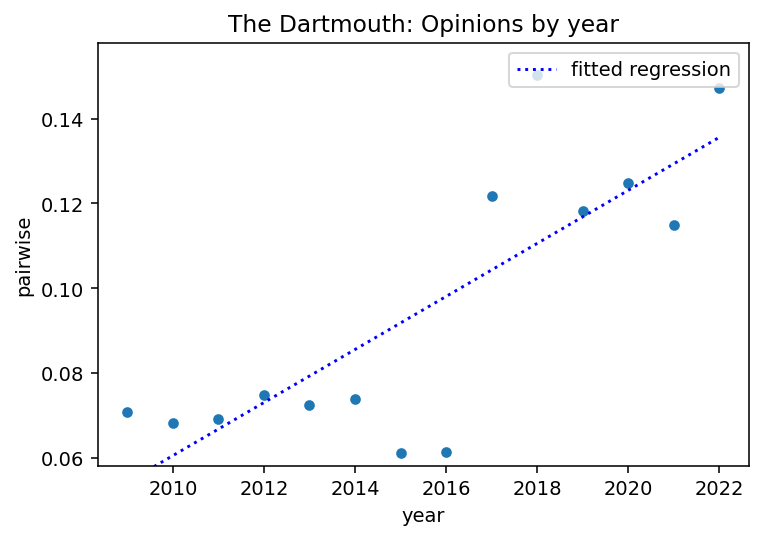

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("The Dartmouth: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mention-norm slope:0.02151, int:0.19656, r:0.74634, p-value:0.00217, se:0.00554, x:range(0, 14)
pairwise slope:0.00625, int:0.05427, r:0.79917, p-value:0.00061, se:0.00136, x:range(0, 14)
trace slope:0.00617, int:1.90593, r:0.50348, p-value:0.06644, se:0.00305, x:range(0, 14)
norm-1 slope:0.00025, int:2.04891, r:0.01573, p-value:0.95745, se:0.00463, x:range(0, 14)
norm-2 slope:-0.00189, int:1.79592, r:-0.12292, p-value:0.67548, se:0.00441, x:range(0, 14)
norm-inf slope:0.00025, int:2.04891, r:0.01573, p-value:0.95745, se:0.00463, x:range(0, 14)


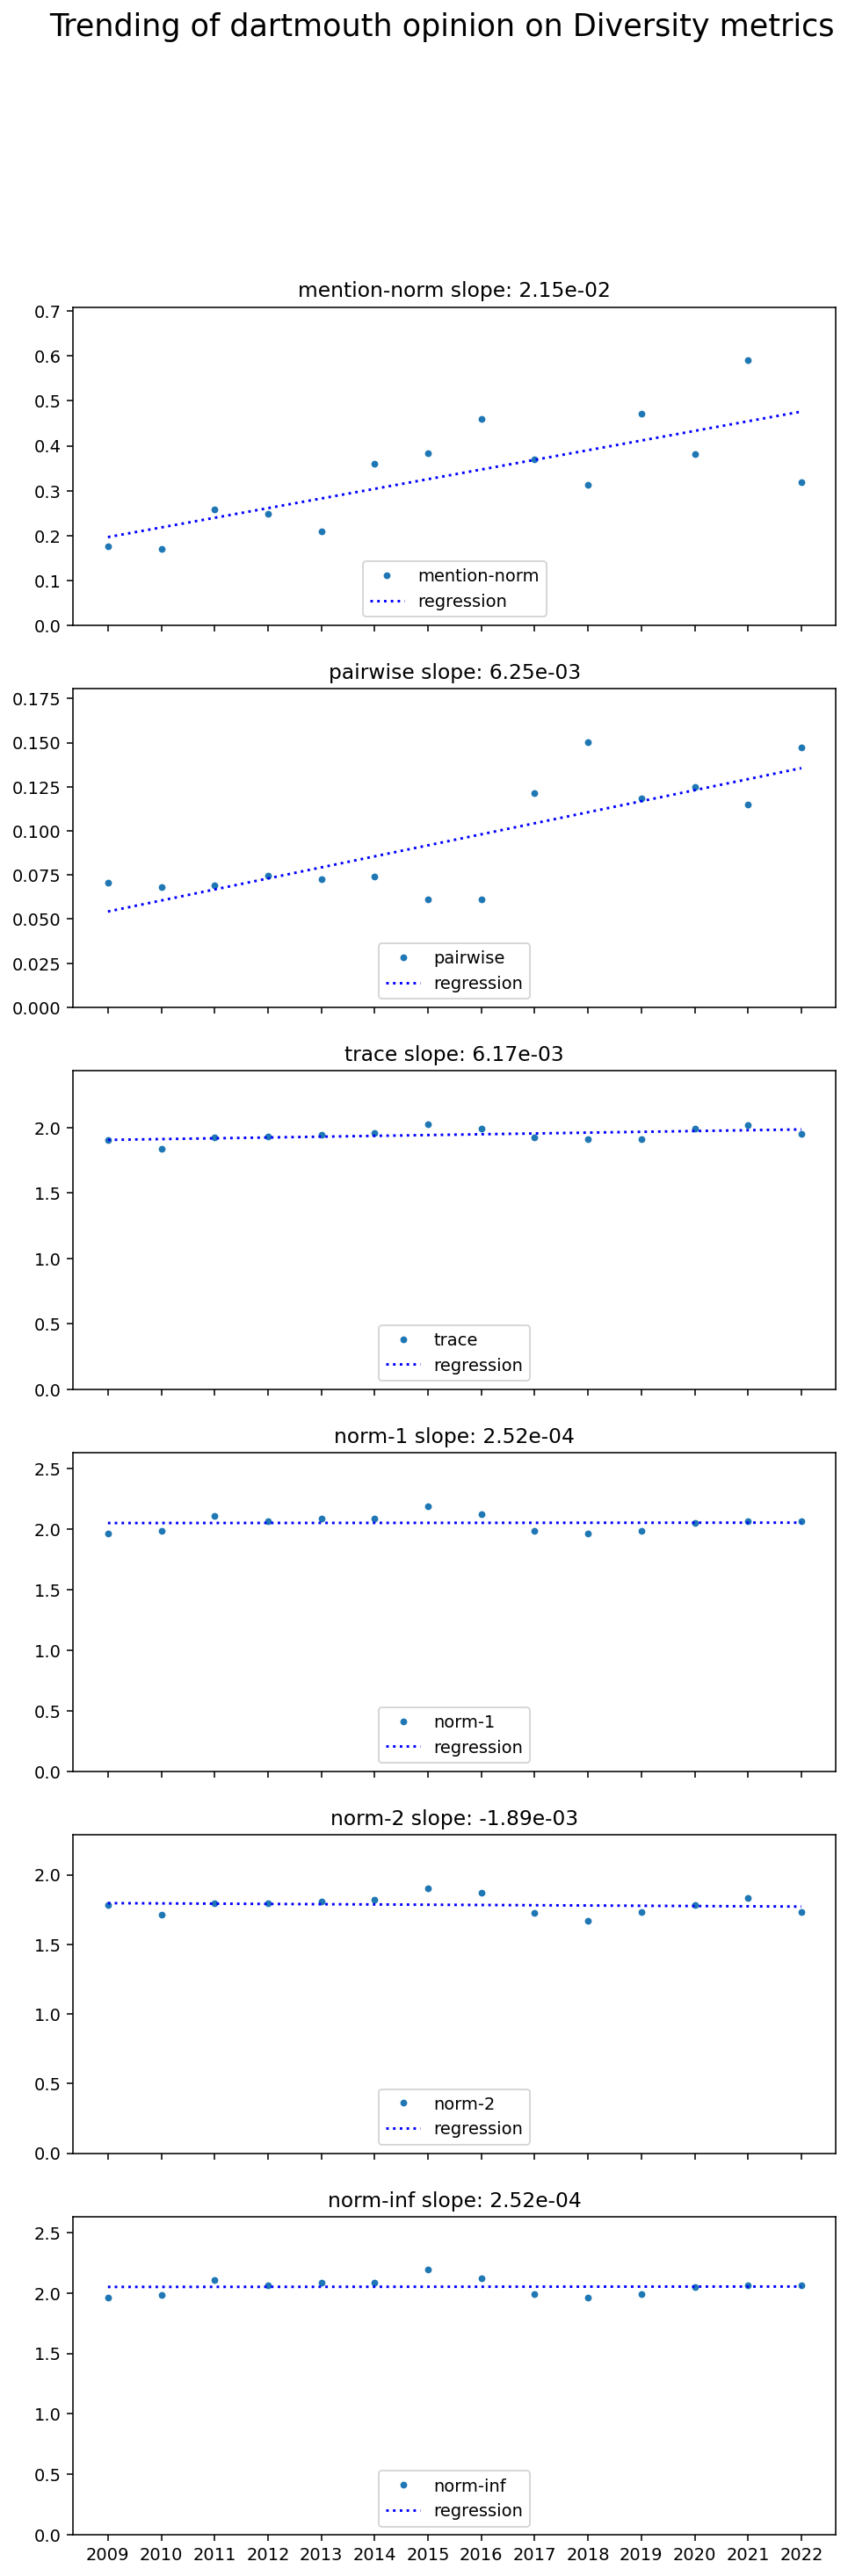

In [16]:
title = "Trending of {} {} on Diversity metrics".format(
    SCHOOL, SUBJECT
)
columns = ["mention-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]
graph = ourgraphs.showTopicsResults(results_df, title, columns)
graph.show()

mention-norm slope:0.02151, int:0.19656, r:0.74634, p:0.00217, se:0.00554, x:range(0, 14)
pairwise slope:0.00625, int:0.05427, r:0.79917, p:0.00061, se:0.00136, x:range(0, 14)


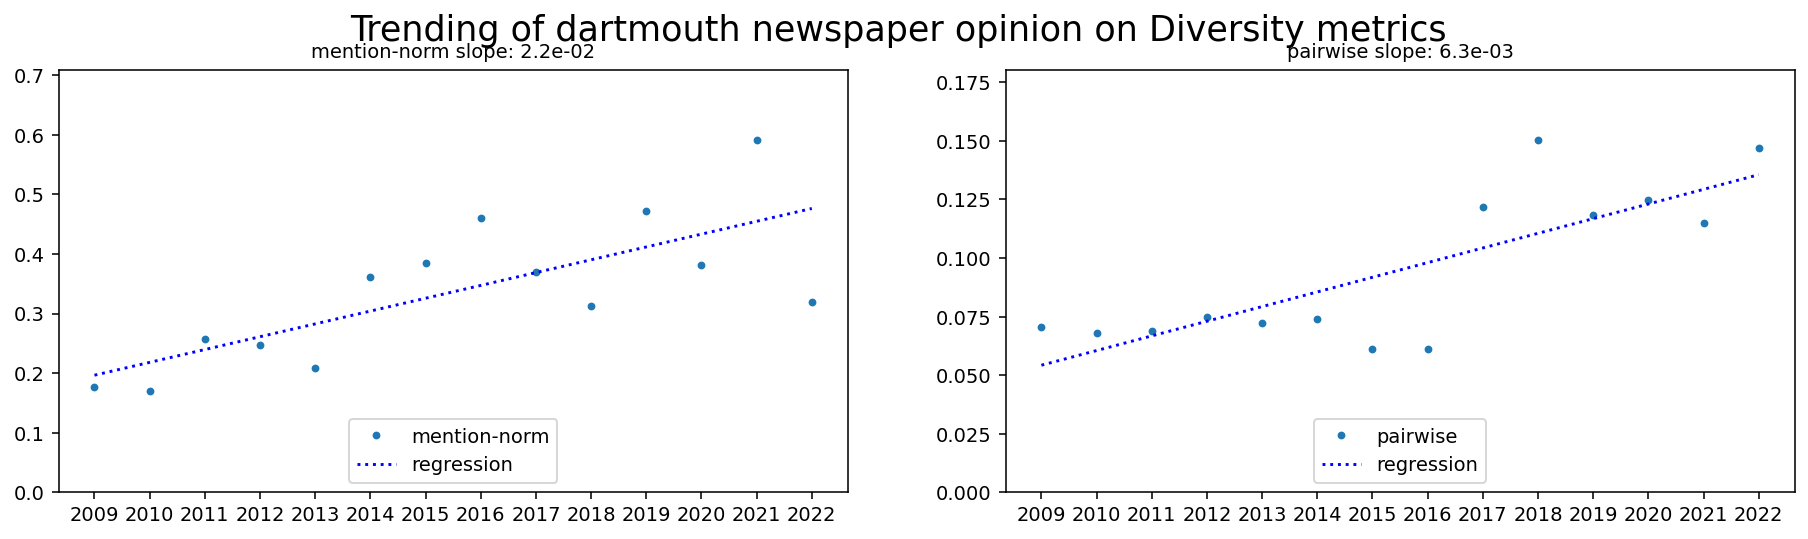

In [17]:
title = "Trending of {} newspaper {} on Diversity metrics\n".format(
    SCHOOL, SUBJECT
)
columns = ["mention-norm", "pairwise"]
graph = ourgraphs.showKeyTopicsResults(results_df, title, columns)
graph.show()

## Topic Modeling

In [46]:
from bertopic import BERTopic

BERTOPIC_FILENAME = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-BERTopic-model"
# to load a saved one: 
#      topic_model = SentenceTransformer.from_pretrained(BERTOPIC_FILENAME)

if os.path.exists(BERTOPIC_FILENAME):
    print("Are you sure that you don't want to load a saved transformer? ")
else:
    topic_model = BERTopic(embedding_model=TOPIC_EMBEDDING_MODEL)

In [47]:
all_docs, num_diversity_words = textutil.filterText(df.body)

In [48]:
# This is a very EXPENSIVE operation: do it with care!
# Alternatively, load it with SentenceTransformer (see above)
topics, probs = topic_model.fit_transform(all_docs.to_list())

In [49]:
topic_model.save(BERTOPIC_FILENAME)

In [50]:
topic_info = topic_model.get_topic_info()
topic_info.shape

(103, 3)

In [51]:
topic_info.head(15)

,Topic,Count,Name
0,-1,1984,-1_it_the_berkeley_one
1,0,175,0_black_white_american_asian
2,1,165,1_asuc_student_senate_candidate
3,2,163,2_sex_sexual_porn_partner
4,3,112,3_dailycal_wp_uploads_https
5,4,109,4_israel_palestinian_jewish_israeli
6,5,108,5_hair_body_beauty_look
7,6,98,6_climate_fossil_fuel_environmental
8,7,85,7_religion_muslim_religious_islam
9,8,76,8_police_officer_bpd_city


In [52]:
topic_model.get_topic(0)

[('black', 0.02024514517228433),
 ('white', 0.01779645044590748),
 ('american', 0.013446671068676428),
 ('asian', 0.012433992226313332),
 ('people', 0.010540848516993547),
 ('chinese', 0.00867100417767298),
 ('culture', 0.008363492791283487),
 ('identity', 0.00831492028244058),
 ('family', 0.007720302113622698),
 ('it', 0.007053674774865069)]

In [53]:
doc_info = topic_model.get_document_info(all_docs.to_list())
doc_info.head(15)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,opening the end semester always come certain l...,18,18_book_writing_write_reading,book - writing - write - reading - read - ve -...,1.000000,False
1,a look economic disparity among asian american...,0,0_black_white_american_asian,black - white - american - asian - people - ch...,0.985940,False
2,spitter quitter nothing used scare looming bre...,2,2_sex_sexual_porn_partner,sex - sexual - porn - partner - orgasm - it - ...,1.000000,False
3,on ignoring matt walsh conservative love sendi...,-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False
4,"what woman? last week, unexpected visitor camp...",50,50_feminist_woman_feminism_women,feminist - woman - feminism - women - men - ge...,0.180283,False
5,"hopping pond when people meet today, fact i gr...",14,14_home_back_road_car,home - back - road - car - ve - place - it - h...,0.931937,False
6,support graduate student throughout doctoral p...,-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False
7,will real republican please stand up? the repu...,69,69_republican_party_democrat_gop,republican - party - democrat - gop - compromi...,1.000000,False
8,"failing uc berkeley someone told me, “if go uc...",-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False
9,"let happiness burn when i child, mom used coll...",-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False


### Visualize Topics

Call `.visualize_topics` to create a 2D representation of your topics. The resulting graph is a plotly interactive graph which can be converted to HTML:

In [54]:
topic_model.visualize_topics()

### Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help to select an appropriate nr_topics when reducing the number of topics that you have created. To visualize this hierarchy, run the following:

In [55]:
topic_model.visualize_hierarchy()

### Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. To visualize this hierarchy, run the following:

In [56]:
topic_model.visualize_barchart()

In [57]:
topic_model.visualize_term_rank()

## Topics over Time


In [58]:
all_docs, all_docs_years = textutil.filterTextWithYears(df.body, df.year)

In [59]:
topics_over_time = topic_model.topics_over_time(all_docs, all_docs_years)

In [60]:
topic_model.visualize_topics_over_time(topics_over_time)

In [61]:
topics_over_time 

,Topic,Words,Frequency,Timestamp,Name
0,-1,"the, student, it, one, berkeley",126,2011,-1_it_the_berkeley_one
1,0,"race, korean, dispute, caucasian, argument",2,2011,0_black_white_american_asian
2,1,"asuc, student, auxiliary, party, change",6,2011,1_asuc_student_senate_candidate
3,2,"sex, orgasm, you, it, partner",26,2011,2_sex_sexual_porn_partner
4,3,"dailycal, wp, uploads, jpg, https",10,2011,3_dailycal_wp_uploads_https
...,...,...,...,...,...
928,89,"mental, health, heat, student, stress",2,2022,89_mental_health_gpa_student
929,92,"bisexual, label, sexuality, straight, gay",3,2022,92_bisexual_sexuality_label_queer
930,93,"neuron, spinal, cord, neurons, autism",1,2022,93_autism_autistic_autistics_neuron
931,96,"earthquake, building, seismic, city, emergency",1,2022,96_earthquake_seismic_building_preparedn...


In [62]:
topics_over_time = topics_over_time[topics_over_time.Topic != -1]

In [63]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
1,0,"race, korean, dispute, caucasian, argument",2,2011,0_black_white_american_asian
2,1,"asuc, student, auxiliary, party, change",6,2011,1_asuc_student_senate_candidate
3,2,"sex, orgasm, you, it, partner",26,2011,2_sex_sexual_porn_partner
4,3,"dailycal, wp, uploads, jpg, https",10,2011,3_dailycal_wp_uploads_https
5,4,"israel, palestinian, israeli, jewish, statehood",3,2011,4_israel_palestinian_jewish_israeli
...,...,...,...,...,...
928,89,"mental, health, heat, student, stress",2,2022,89_mental_health_gpa_student
929,92,"bisexual, label, sexuality, straight, gay",3,2022,92_bisexual_sexuality_label_queer
930,93,"neuron, spinal, cord, neurons, autism",1,2022,93_autism_autistic_autistics_neuron
931,96,"earthquake, building, seismic, city, emergency",1,2022,96_earthquake_seismic_building_preparedn...


In [64]:
len(topic_model.topic_embeddings_[0])

384

### Extract topic embeddings for each year

In [65]:
results = []
for year in range(2011, 2023):
    topics_series = topics_over_time[topics_over_time.Timestamp==year].Topic
    
    topic_embeddings = []
    for topic in topics_series:
        topic_embeddings.append(topic_model.topic_embeddings_[topic])
    pairwise_measure = textutil.getNormalizedPairwiseDispersion(topic_embeddings)
    cov = textutil.getCovDispersion(topic_embeddings)
        
    results.append({
        'year': year,
        'topics_count': topics_series.nunique(),
        'size'        : df[df.year == year].shape[0],
        'topics_norm' : topics_series.nunique() / df[df.year == year].shape[0],
        'pairwise'    : pairwise_measure,
        'trace'       : cov[1],
        'norm-1'      : cov[2],
        'norm-2'      : cov[3],
        'norm-inf'    : cov[4]
    })
    
topics_trend_df = pd.DataFrame.from_records(results)

In [66]:
topics_trend_df.set_index('year')

,topics_count,pairwise,trace,norm-1,norm-2,norm-inf
year,,,,,,
2011,62,0.405426,0.001196,0.000793,0.000713,0.000793
2012,77,0.414340,0.001191,0.000784,0.000698,0.000784
2013,82,0.420013,0.001202,0.000787,0.000697,0.000787
2014,76,0.414980,0.001194,0.000789,0.000698,0.000789
2015,83,0.412356,0.001186,0.000789,0.000697,0.000789
2016,83,0.417408,0.001195,0.000788,0.000695,0.000788
2017,84,0.414436,0.001194,0.000788,0.000698,0.000788
2018,82,0.416560,0.001190,0.000782,0.000694,0.000782
2019,79,0.415513,0.001188,0.000783,0.000694,0.000783


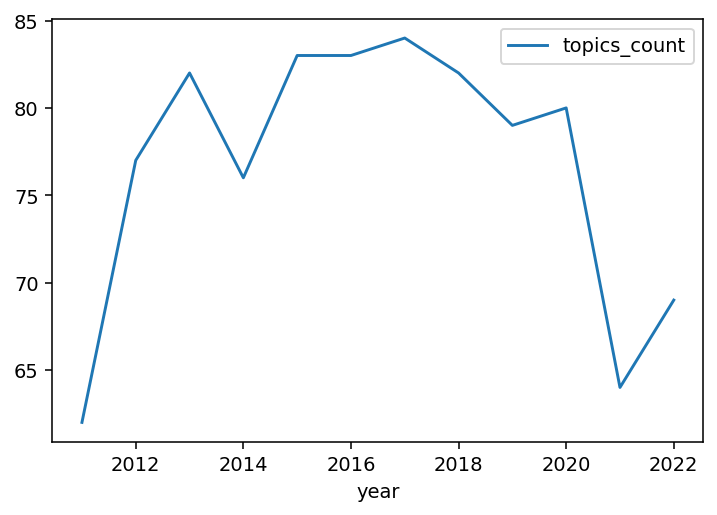

In [67]:
topics_trend_df.plot(x='year', y='topics_count', kind='line')

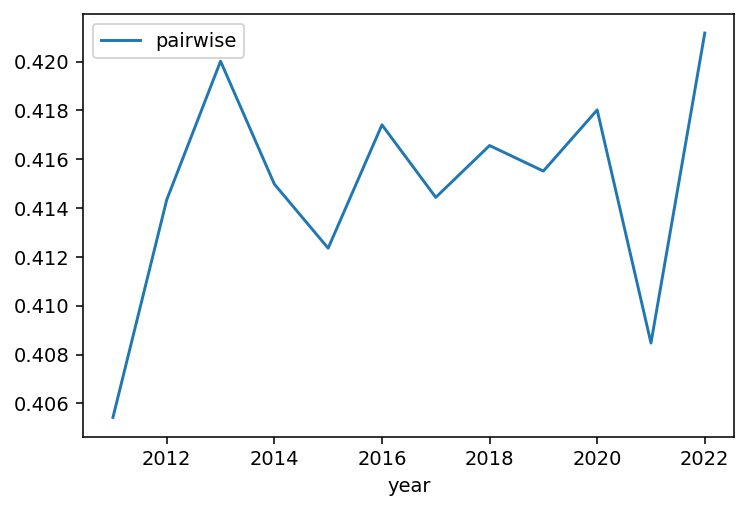

In [68]:
topics_trend_df.plot(x='year', y='pairwise', kind='line')

topics_count slope:-0.14336, int:77.53846, r:-0.06764, p-value:0.83454, se:0.66863, x:range(0, 12)
pairwise slope:0.00041, int:0.41261, r:0.33257, p-value:0.29087, se:0.00037, x:range(0, 12)
trace slope:-0.00000, int:0.00120, r:-0.70798, p-value:0.00999, se:0.00000, x:range(0, 12)
norm-1 slope:-0.00000, int:0.00079, r:-0.56231, p-value:0.05703, se:0.00000, x:range(0, 12)
norm-2 slope:-0.00000, int:0.00070, r:-0.57726, p-value:0.04937, se:0.00000, x:range(0, 12)
norm-inf slope:-0.00000, int:0.00079, r:-0.56231, p-value:0.05703, se:0.00000, x:range(0, 12)


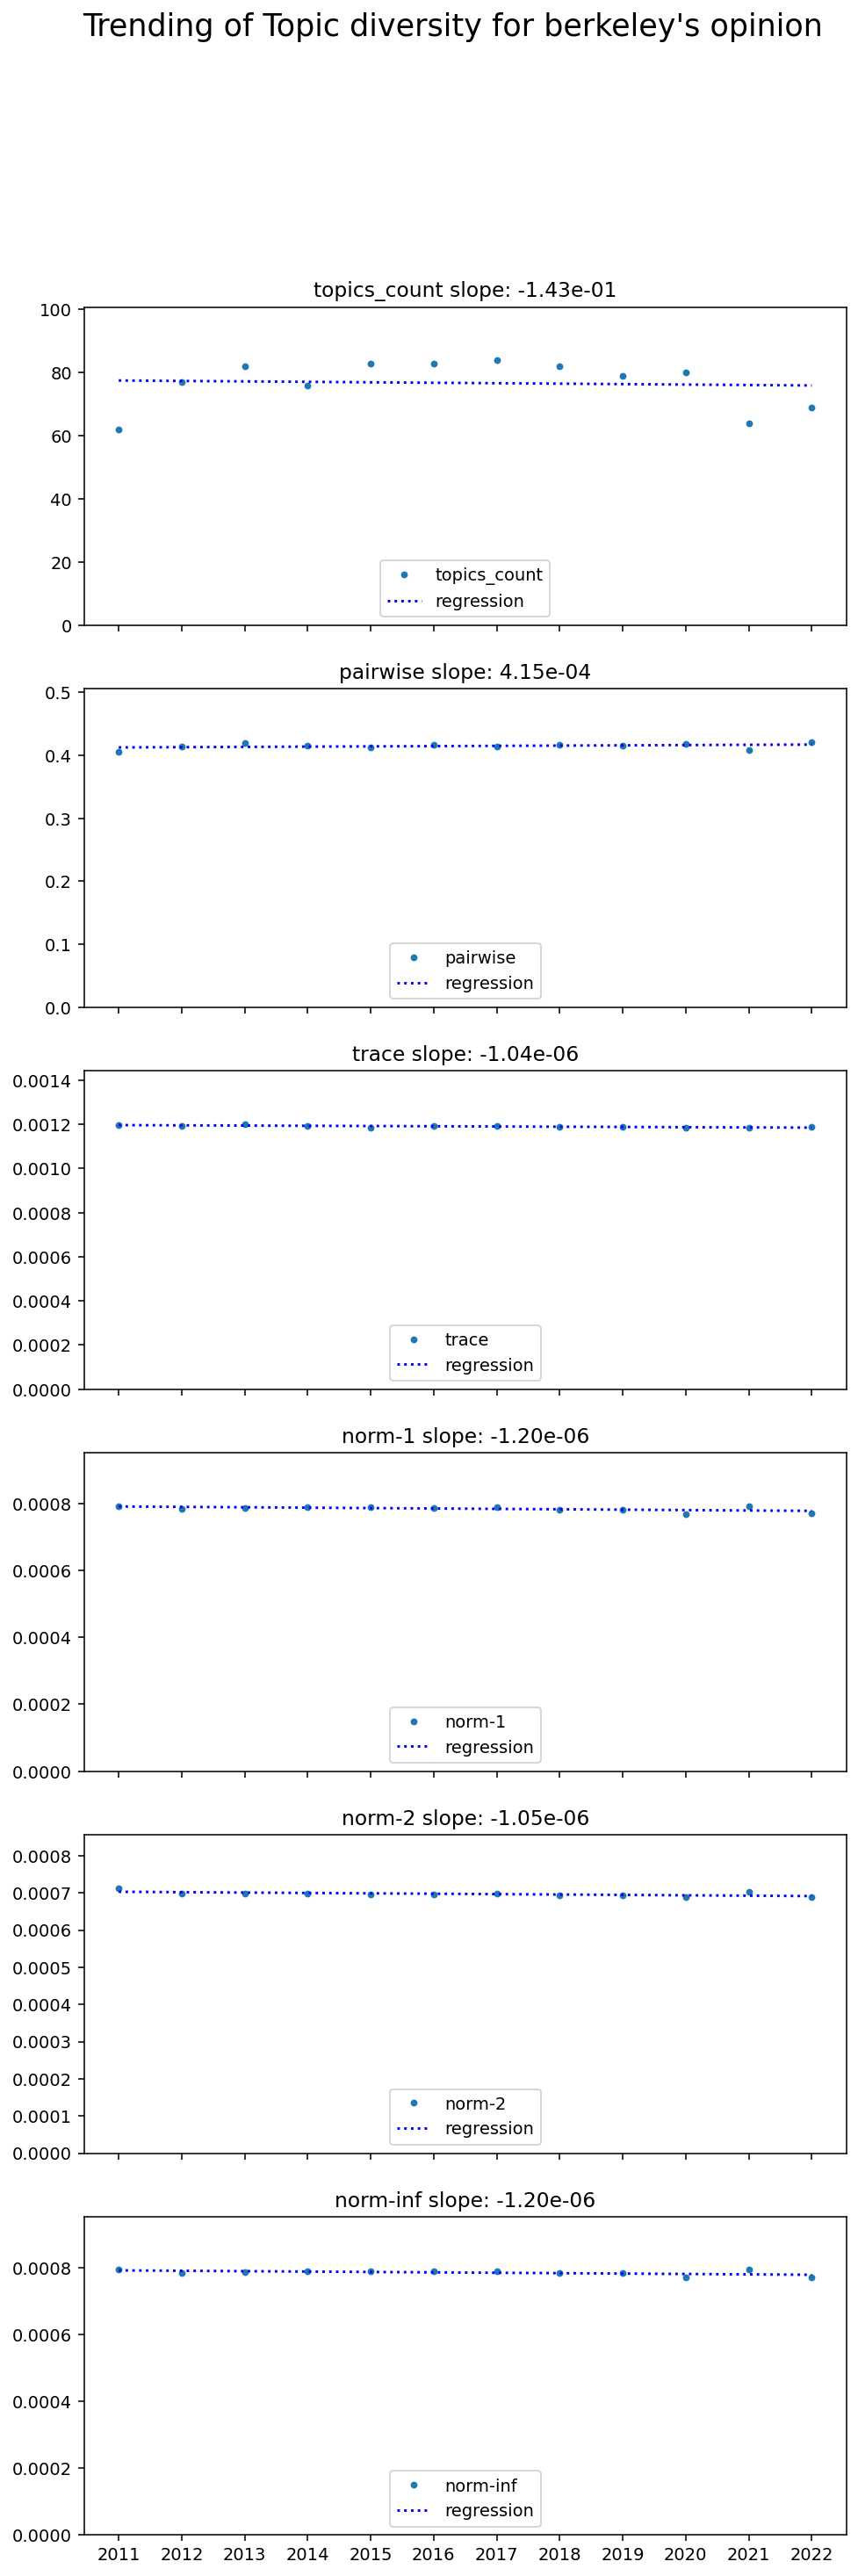

In [69]:
title = "Trending of Topic diversity for {}'s {}".format(
    SCHOOL, SUBJECT
)
columns = ["topics_count", "pairwise", 'trace', 'norm-1', 'norm-2', 'norm-inf']
graph = ourgraphs.showTopicsResults(topics_trend_df, title, columns)
graph.show()

topics_count slope:-0.14336, int:77.53846, r:-0.06764, p:0.83454, se:0.66863, x:range(0, 12)
pairwise slope:0.00041, int:0.41261, r:0.33257, p:0.29087, se:0.00037, x:range(0, 12)


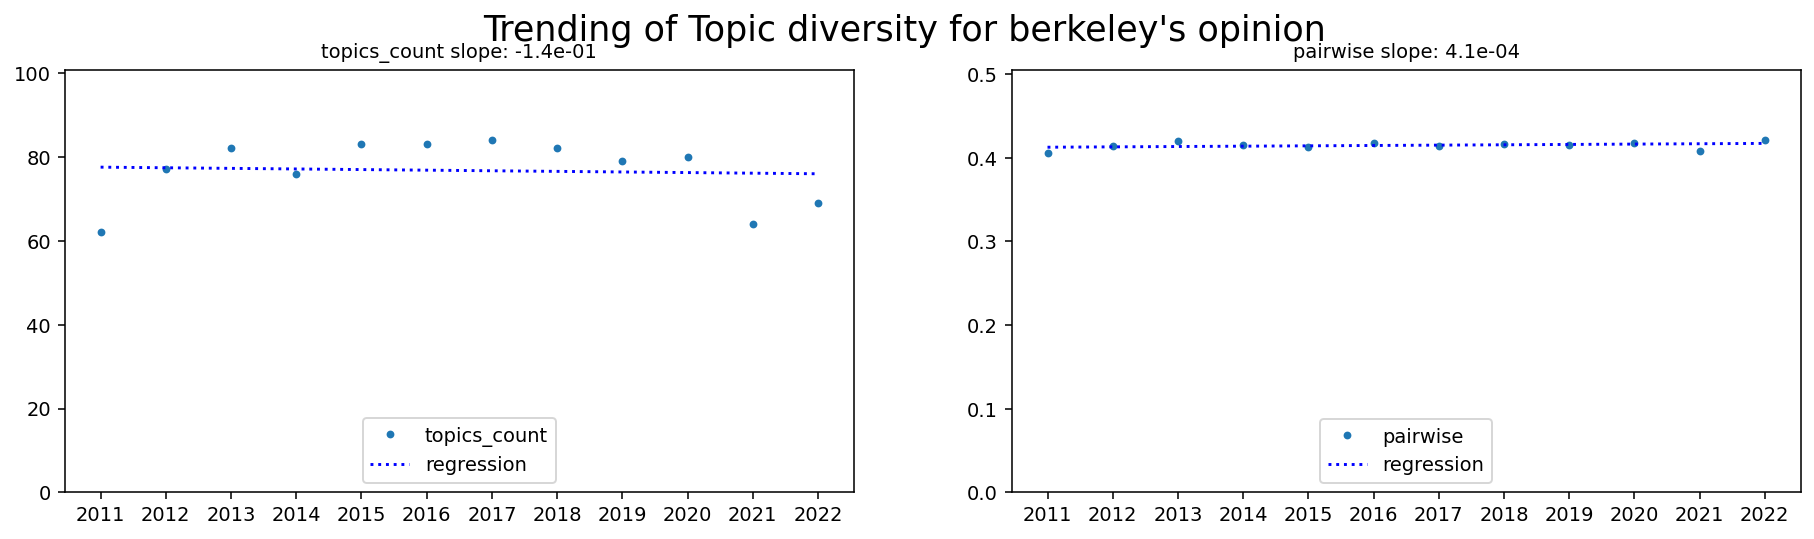

In [71]:
title = "Trending of Topic diversity for {}'s {}\n".format(
    SCHOOL, SUBJECT
)
columns = ["topics_count", "pairwise"]
graph = ourgraphs.showKeyTopicsResults(topics_trend_df, title, columns)
graph.show()

In [72]:
all_topics = topic_model.get_topics()
len(all_topics)

103

### Optionally: remove topic '2' which seems to be an outlier

In [ ]:
del all_topics[3]

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=all_topics.keys())